In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

In [2]:
# Function to get the DCT of the sub-images/blocks
def dct2D(img):
    tmp = dct(img, type=2 ,norm='ortho').transpose()
    return dct(tmp, type=2 ,norm='ortho').transpose()

# Function to get the zig-zag scan of the quantized DCT coefficients
def zigzagScan(img):
    hmin = 0
    wmin = 0
    hmax = img.shape[0] - 1
    wmax = img.shape[1] - 1
    h = hmin
    w = wmin
    scan = np.zeros((img.shape[0] * img.shape[1]), dtype=np.int16)
    i = 0
    while h <= hmax and w <= wmax:
        # print(h, w)
        # Going up
        if (h + w) % 2 == 0:
            # Last column
            if w == wmax:
                scan[i] = img[h, w]
                h += 1
                i += 1
            # First row
            elif h == hmin:
                scan[i] = img[h, w]
                w += 1
                i += 1
            # Other cases
            else:
                scan[i] = img[h, w]
                h -= 1
                w += 1
                i += 1
        # Going down
        else:
            # Last row
            if h == hmax:
                scan[i] = img[h, w]
                w += 1
                i += 1
            # First column
            elif w == wmin:
                scan[i] = img[h, w]
                h += 1
                i += 1
            # Other cases
            else:
                scan[i] = img[h, w]
                h += 1
                w -= 1
                i += 1
    return scan

# Function to get the quantization matrix according to the block size
def quantizationMatrix(blockSize, flag=0):
    # Defining the standard quantization matrix for JPEG compression
    Q1 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])
    Q2 = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99]])
    if blockSize == [8, 8]:
        if flag == 0:
            return Q1
        if flag == 1:
            return Q2
    else:
        Q1 = np.resize(Q1, (blockSize[0], blockSize[1]))
        Q2 = np.resize(Q2, (blockSize[0], blockSize[1]))
        if flag == 0:
            return Q1
        if flag == 1:
            return Q2
    pass

In [3]:
def jpeg_encode(img, blockSize, numberOfCoefficients, flag=0):
    h, w = img.shape
    
    # Size of each block
    a, b = blockSize
    size = a * b

    # Dividing the image into sub-images/blocks
    subImages = np.zeros((h//a, w//b, a, b), dtype=np.int16)
    for i in range(0, h, a):
        for j in range(0, w, b):
            subImages[i//a][j//b] = (img[i:i+a, j:j+b])

    # Subtracting 128 from each value in the sub-images
    subImages -= 128 

    # Applying DCT to each 8x8 block
    dctImages = np.zeros((h//a, w//b, a, b), dtype=np.float16)
    for i in range(h//a):
        for j in range(w//b):
            dctImages[i][j] = dct2D(subImages[i][j])

    # Defining the standard quantization matrix for JPEG compression
    Q = quantizationMatrix(blockSize, flag)

    # Quantizing the DCT coefficients
    quantized = np.zeros((h//a, w//b, a, b), dtype=np.int16)
    for i in range(h//a):
        for j in range(w//b):
            quantized[i][j] = np.round(dctImages[i][j]/Q)

    # Zigzag scanning
    zigzag = np.zeros((h//a, w//b, size), dtype=np.int16)
    for i in range(h//a):
        for j in range(w//b):
            zigzag[i][j] = zigzagScan(quantized[i][j])

    # Obtaining the final JPEG encoded integer array
    jpegCompressed = []
    for i in range(h//a):
        for j in range(w//b):
            if numberOfCoefficients == 0:
                k = 63
                while k >= 0 and zigzag[i][j][k] == 0:
                    k -= 1
                k += 1
                for l in range(k):
                    jpegCompressed.append(zigzag[i][j][l])
            else:
                for k in range(numberOfCoefficients):
                    jpegCompressed.append(zigzag[i][j][k])
    
    return jpegCompressed


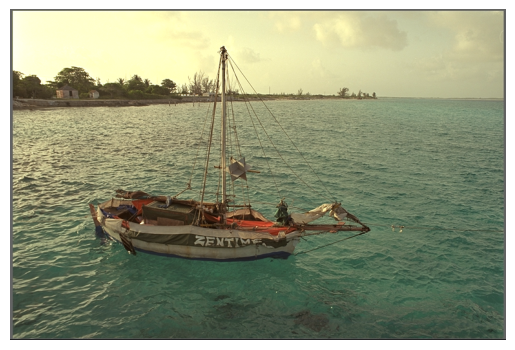

In [4]:
# filename = input("Enter the filename: ")
filename = "img.png"
# blockSize = input("Enter the block size: ")
blockSize = [8, 8]
# numberOfCoefficients = input("Enter the number of coefficients: ")
numberOfCoefficients = 15
# color = input("Enter the color space (0 for gray-scale and 1 for RGB): ")
color = 1

img = cv.imread(filename, color)

# Gray-scale images
if color == 0:
    plt.imshow(img, cmap='gray'); plt.axis('off')
    jpegEncodedArray = jpeg_encode(img, blockSize, numberOfCoefficients)

# RGB images
if color == 1:
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img); plt.axis('off')
    img = cv.cvtColor(img, cv.COLOR_RGB2YCrCb)
    jpeg1 = jpeg_encode(img[:,:,0], blockSize, numberOfCoefficients, 0)
    jpeg2 = jpeg_encode(img[:,:,1], blockSize, numberOfCoefficients, 1)
    jpeg3 = jpeg_encode(img[:,:,2], blockSize, numberOfCoefficients, 1)
    jpegEncodedArray = np.concatenate((jpeg1, jpeg2, jpeg3))

# Saving the JPEG encoded array to a text file
file = open("img_jpegcode.txt", "w")
for i in range(len(jpegEncodedArray)):
    file.write(str(jpegEncodedArray[i]) + " ")
file.close()